In this notebook we would like to use some Bio.PDB library to use Biopython for several use cases in structural analyses.

For the 1st to 4th problems we will use 2PTC protein which you can acces on https://www.rcsb.org/structure/2PTC. From the page, we can see that the protein has two main entities: Chain E (Trypsin) and Chain I (Trypsin Inhibitor)

In [1]:
from Bio.PDB import PDBList
from Bio.PDB import PDBParser
from Bio.PDB import Chain
from Bio.PDB import PPBuilder
from Bio.PDB import calc_dihedral
from Bio.PDB import PDBIO
from Bio.PDB import Select
from Bio.PDB import CaPPBuilder
from Bio.PDB import Vector
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pdb_list = PDBList()
parser = PDBParser()

file_name = pdb_list.retrieve_pdb_file(pdb_code="2ptc", file_format="pdb", pdir="data")
structure = parser.get_structure("Trypsin", file_name)

Structure exists: 'data/pdb2ptc.ent' 


/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 2692.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2815.
  warnings.warn(


### Problem 1: Finding Close Contact of Two Residues

Two residues are in close contact if there are more than 2 close atom pairs which < 3.5 Amstrong 

In [3]:
chain_e = structure[0]["E"]
chain_i = structure[0]["I"]

In [4]:
def close_contacts(chain_a:Chain, chain_b:Chain) -> list((str, str)):
    """
    Return the list of possible close residue(s) of two chains
    Arg:
        chain_a: Chain object of BioPython
        chain_b: Chain object of BioPython
    Return:
        List of close residues        
    """
    close_res_list = []

    for residue_a in chain_a: 
        for residue_b in chain_b:
            break_flag = False
            close_count = 0
            for atom_a in residue_a:
                for atom_b in residue_b: 
                    dist = atom_a - atom_b
                    if dist < 3.5:  
                        close_count += 1 
                    if close_count > 2:
                        break_flag = True
                        break
                if break_flag:
                    close_res_list.append((residue_a.get_resname() + str(residue_a.get_id()[1]), residue_b.get_resname() + str(residue_b.get_id()[1])))
                    break    
    return close_res_list



In [5]:
close_residues = close_contacts(chain_e, chain_i)
print(close_residues)

[('PHE41', 'ARG17'), ('ASN97', 'ARG39'), ('SER190', 'LYS15'), ('SER195', 'LYS15')]


### Problem 2: Finding Phi and Psi Angles 

Phi and Psi angle are the rotatin angle in protein which affect its shape. We can refer to the Ramachandran plot to check the quality of the structure data. In this section we would like to calculate the angles by two methods: using the PPBuilder built-in method and by manually calculating it with calc_dihedral().

If you are not familiar with phi and psi angles please take a look on the below image

![torsion_angles](images/torsion_angles.png)

#### 2.1 Using Polypeptide Class

In [24]:
PPBuild = PPBuilder()
pp = PPBuild.build_peptides(structure)
for peptide in pp:
    # Print the phi and psi angles
    print(peptide)
    # Print only the first five dihedral angels
    print(peptide.get_phi_psi_list()[0:5])    

<Polypeptide start=16 end=245>
[(None, 2.086358562797179), (-1.5875678985581017, 2.227954438616829), (1.5205611604809084, 0.167044553393296), (-1.5887534062133128, -2.744849399749058), (-2.4140380469249436, 2.912327266695439)]
<Polypeptide start=1 end=58>
[(None, -0.899906123177191), (-1.0975668290123755, -3.1110651780922565), (-1.4689327072244405, -0.4421298658371011), (-1.2242851460064887, -0.39783831629951966), (-1.2212252876472187, -0.12958617487590884)]


#### 2.2 Using calc_dehidral()

In [25]:
def get_calc_phi_psi(chain: Chain) -> list((float, float)):
    "Get the phi and psi angle via calc_dihedral from a chain"
    phi_psi_list =[]

    residues = chain.get_list()
    pp = []
    # Fitlering the polypeptide
    for residue in residues: 
        if residue.get_id()[0]==" " and residue.get_id()[2]==" ": 
            pp.append(residue)


    # Get the phi_psi_list
    for i in range(len(pp)): 
        cur_res = pp[i]
        if i==0: 
            phi = None
            next_res = pp[i+1]
            psi = calc_dihedral(cur_res["N"].get_vector(), cur_res["CA"].get_vector(), cur_res["C"].get_vector(), next_res["N"].get_vector())
        elif i==len(pp)-1:
            psi = None
            prev_res = pp[i-1]
            phi = calc_dihedral(prev_res["C"].get_vector(), cur_res["N"].get_vector(), cur_res["CA"].get_vector(), cur_res["C"].get_vector())
        else:
            prev_res = pp[i-1]
            next_res = pp[i+1]
            psi = calc_dihedral(cur_res["N"].get_vector(), cur_res["CA"].get_vector(), cur_res["C"].get_vector(), next_res["N"].get_vector())
            phi = calc_dihedral(prev_res["C"].get_vector(), cur_res["N"].get_vector(), cur_res["CA"].get_vector(), cur_res["C"].get_vector())
        
        phi_psi_list.append((phi, psi))

    return phi_psi_list

In [27]:
for chain in structure[0]:
    print("Chain name: " + str(chain.id))
    # Print only the first five dihedral angels
    phi_psi = get_calc_phi_psi(chain)
    print(phi_psi[0:5])

Chain name: E
[(None, 2.086358562797179), (-1.5875678985581017, 2.227954438616829), (1.5205611604809084, 0.167044553393296), (-1.5887534062133128, -2.744849399749058), (-2.4140380469249436, 2.912327266695439)]
Chain name: I
[(None, -0.899906123177191), (-1.0975668290123755, -3.1110651780922565), (-1.4689327072244405, -0.4421298658371011), (-1.2242851460064887, -0.39783831629951966), (-1.2212252876472187, -0.12958617487590884)]


As we can see, our calculated dihedral angles is the same as the BioPDB built-in function

### Problem 3: Output Trypsin into separate PDB File

Output only the trypsin chain to another PDB File

In [9]:
io = PDBIO()

class TrypsinSelect(Select):
    def accept_chain(self, chain):
        if chain.get_id() == "E":
            return True
        else:
            return False

io.set_structure(structure)

select = TrypsinSelect()
io.save("Data/trypsin_out.pdb", select)

In [10]:
# Check the output file. Expected output: "E" only
trypsin_structure = parser.get_structure("Trypspin", "Data/trypsin_out.pdb")

for chain in trypsin_structure[0]:
    print(chain.get_id())

E


### Problem 4: Output Atoms Within Sphere

In [11]:
# Calculating the center of Chain E 
pp_builder = CaPPBuilder()
pp = pp_builder.build_peptides(chain_e)

def center_of_mass_via_ppbuild(peptide):
    ca_list = peptide.get_ca_list()
    ca_pos = np.empty((len(ca_list), 3), dtype="d")
    for i in range(len(ca_list)):
        ca_pos[i] = ca_list[i].get_vector().get_array()
    com = np.mean(ca_pos, axis=0) 
    print("Center of mass: ", com)
    return com

class CenterDistPPSelect(Select):
    def __init__(self, center):
        self.center = center

    def accept_atom(self, atom):
        if np.linalg.norm(atom.get_vector().get_array() - center) < 10:
            return 1
        else:
            return 0 

# The below code is the same as the above
# It only shows that we can select based on the Structure object
# (not) directly from the PP Object            

def center_of_mass_via_vector(chain):
    ca_pos_sum = Vector(0., 0., 0.)
    count_ca = 0
    for residue in chain: 
        # Filter for peptide only
        if residue.get_id()[0]== " " and residue.has_id("CA") and residue.get_id()[2]== " " :
            ca_pos_sum += residue["CA"].get_vector()
            count_ca += 1
    if count_ca>0:
        center = Vector(ca_pos_sum.get_array() * (1/count_ca))
        return center 
    else:
        return None

class CenterDistVectSelect(Select):
    def __init__(self, center):
        self.center = center

    def accept_atom(self, atom):
        if np.linalg.norm(atom.get_vector() - center) < 10:
            return 1
        else:
            return 0 

io = PDBIO()

io.set_structure(structure)
center = center_of_mass_via_ppbuild(pp[0])
select = CenterDistPPSelect(center)
io.save("Data/trypsin_spehere_ppbuild.pdb", select)


center = center_of_mass_via_vector(chain_e)
select = CenterDistVectSelect(center)
io.save("Data/trypsin_spehere_vectbuild.pdb", select)

Center of mass:  [10.42219731 65.12975313 19.74986104]


### Problem 5: Superposition

Superposition is one of the problem when dealing with protein structure data. With superposition, we can determine whether a particular protein relates to another protein hence it can give you the functionality of the protein due to structure information is more conserve in evolution processes. 

First, we want to draw the structure of the trypsin (You can play and move around with the interactive structure e.g. showing cartoon or stick, moving and rotating etc.)

In [38]:
import nglview as nv
import ipywidgets
from Bio.PDB import Superimposer

view = nv.show_biopython(structure)
view.display(gui=True)

NGLWidget(gui_style='ngl')

Then, we import *1trn* protein to be superimposed to 

In [39]:
file_name_1trn = pdb_list.retrieve_pdb_file("1TRN", file_format="pdb", pdir="data")
structure_1trn = parser.get_structure("Trypsin", file_name_1trn)

view = nv.show_biopython(structure_1trn)
view.display(gui=True)
view

Structure exists: 'data/pdb1trn.ent' 


/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3860.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3867.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3874.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4026.
  warnings.warn(


NGLWidget(gui_style='ngl')

We would like to use classic RMSD algorithm both from scratch and BIOPDB library. To do so, we have to know the linear algebra behind it. 

A protein structure is a set of 3D structure. 
Suppose we have 2 sets of {3 x n} matrix, $\mathbf{X}$ and $\mathbf{y}$ (**assume they are centered**). We want to superimpose y into x. One metric to evaluate it is using RMSD: 


$RMSD(x,y) = \sqrt{ \frac{1}{n} \sum_{i=0}^{n-1} |\mathbf{x}_{i} - \mathbf{y}_{i}|^{2}  }$

We expect that $\mathbf{Y}$ is transformed (rotated and translated) with $\mathbf{U}$ so that the RMSD is minimized

$RMSD(x,y) = min_{\mathbf{U}}\lr{\sqrt{ \frac{1}{n} \sum_{i=0}^{n-1} |\mathbf{x}_{i} - \mathbf{U}\mathbf{y}_{i}|^{2}}}$

It equals to minimize: 

$E(U) = \sum_{i=0}^{n-1}(|\mathbf{x}_{i}|^{2} + |\mathbf{y}_{i}|^{2}) - 2\sum_{i=0}^{n-1}(\mathbf{x}_{i}^{T}\mathbf{U}\mathbf{y}_{i})$

$E(U) = E_{0} - 2L(U)$

$L(U) = Tr(\mathbf{X}^{T}\mathbf{U}\mathbf{Y})$

$L(U) = Tr(\mathbf{U}\mathbf{Y}\mathbf{X}^{T})$

$L(U) = Tr(\mathbf{U}\mathbf{R})$

$R = \mathbf{Y}\mathbf{X}^{T} = \mathbf{V}\mathbf{S}\mathbf{W}^{T}$ where the latter comes from singular value decomposition

$L(U) = Tr(\mathbf{U}\mathbf{V}\mathbf{S}\mathbf{W}^{T})$

$L(U) = Tr(\mathbf{S}\mathbf{W}^{T}\mathbf{U}\mathbf{V})$

$L = Tr(\mathbf{S}\mathbf{T}) = \sigma_{1}T_{11} + \sigma_{2}T_{22} + \sigma_{3}T_{33}$ To maximize it, $\mathbf{T}$ has to be 1. So, $\mathbf{T}$ is identity matrix.




In [40]:
class SuperImposeScratch(): 
    def __init__(self):
        self.coords = None
        self.moved_coords = None
        self.centered_coords = None
        self.centered_moved_coords = None
        self.rotated_coords = None
        self.eigen_s = None
    
    def _graph_coords(self, a, b, label_a="a", label_b="b", title="Superimpose of a and b"):
        ax = plt.figure().add_subplot(projection="3d")
        ax.plot(a[0, :], a[1, :], a[2, :], label="a")
        ax.plot(b[0, :], b[1, :], b[2, :], label="b")
        ax.set_title(title)
        plt.legend()
        plt.show()

    def set(self, coords, moved_coords): 
        self.coords = coords
        self.moved_coords = moved_coords

    def _centering(self, coords):
        coords_mean = np.mean(coords, axis=1, keepdims=True)
        centered_coords = coords - coords_mean
        return centered_coords

    def _get_init_rmsd(self):
        diff = self.centered_coords - self.centered_moved_coords
        rmsd = np.sqrt(np.sum(np.square(diff)) / self.moved_coords.shape[1])
        return rmsd 
    
    def _rmsd_rot_coord(self):
        diff = self.centered_coords - self.rotated_coords
        rmsd = np.sqrt(np.sum(np.square(diff)) / self.rotated_coords.shape[1])
        return rmsd 

    def _rmsd_with_formula(self):
        sum_eigen = np.sum(self.eigen_s)
        e_0 = np.sum(np.square(self.centered_coords) + np.square(self.centered_moved_coords))
        rmsd = np.sqrt( (e_0 - 2*sum_eigen)  / self.rotated_coords.shape[1])
        return rmsd


    def run(self):
        self._graph_coords(self.coords, self.moved_coords, title="Initial coordinate")


        self.centered_coords = self._centering(self.coords)
        self.centered_moved_coords = self._centering(self.moved_coords)

        self._graph_coords(self.centered_coords, self.centered_moved_coords, title="Centered coordinate")
        print("Init RMSD: {}".format(self._get_init_rmsd()))

        R = np.matmul(self.centered_moved_coords, self.centered_coords.T)

        v, s, wt = np.linalg.svd(R)
        self.eigen_s = np.diag(s)

        z = np.diag(np.array([1,1,-1]))

        u = np.matmul(wt.T, v.T)

        u_det = np.linalg.det(u)
        if np.isclose(u_det, -1):
            u = np.matmul(np.matmul(wt.T,z), v.t)
    
        self.rotated_coords = np.matmul(u, self.centered_moved_coords)

        self._graph_coords(self.centered_coords, self.rotated_coords, title="Rotated coordinate")
        print("Rotation matrix:\n{}".format(u))
        print("RMSD with rotation calc: {}".format(self._rmsd_rot_coord()))
        print("RMSD with formula calc: {}".format(self._rmsd_with_formula()))

Since in the RMSD we assume that the length of the two proteins are the same, we should choose the (potentially) same chains. From the PDB page we know that Chain E on 2PTC is suppose to be the same as Chain A of 1TRN. Due to they are exactly almost the same, we apply some translation and rotaion to the 1trn.

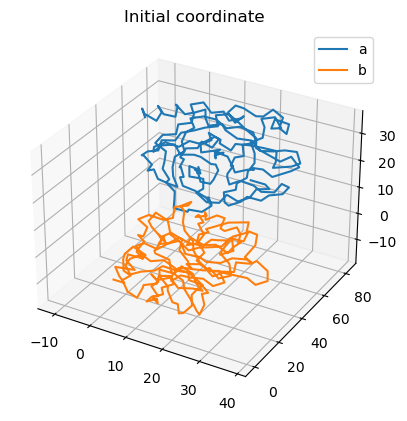

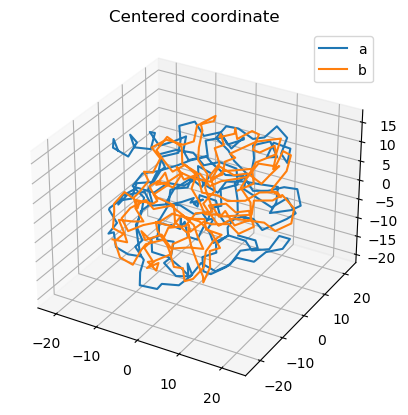

Init RMSD: 16.98157042215161


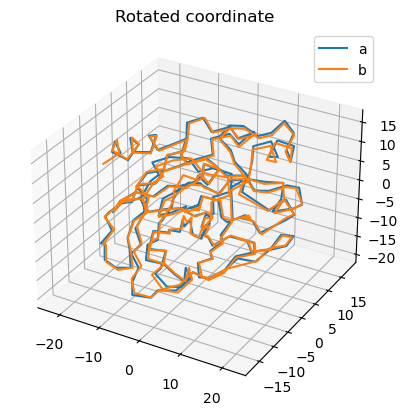

Rotation matrix:
[[ 0.63626738  0.41596754  0.64971904]
 [ 0.50874155  0.40687928 -0.75870369]
 [-0.57995332  0.81327748  0.04726405]]
RMSD with rotation calc: 2.5236861713755974
RMSD with formula calc: 2.523686171375614


In [41]:
ppb1 = pp_builder.build_peptides(structure_1trn)
ppb2 = pp_builder.build_peptides(structure)

sel_2ptc = ppb2[0].get_ca_list()
sel_1trn = ppb1[0].get_ca_list() + ppb1[1].get_ca_list()

def get_ca_coordinate(chain: Chain):
    ca_coord = []
    for res in chain:
        if res.get_id()[0]==" " and res.get_id()[2]==" ":
            ca_coord.append(res["CA"].get_vector().get_array())

    ca_coord = np.array(ca_coord)
    return ca_coord.T

chain_e_2ptc_coord = get_ca_coordinate(structure[0]["E"])
chain_ab_1trn_chain_coord = get_ca_coordinate(structure_1trn[0]["A"])

sp = SuperImposeScratch()
sp.set(chain_e_2ptc_coord, chain_ab_1trn_chain_coord)
sp.run()



In [37]:

sp = Superimposer()

def get_atoms(chain: Chain):
    atoms = []
    for res in chain:
        if res.get_id()[0]==" " and res.get_id()[2]==" ":
            atoms.append(res["CA"])

    atoms = np.array(atoms)
    return atoms

chain_e_2ptc_atoms = get_atoms(structure[0]["E"])
chain_ab_1trn_chain_atoms = get_atoms(structure_1trn[0]["A"])
sp.set_atoms(chain_e_2ptc_atoms,chain_ab_1trn_chain_atoms)

sp.apply(sel_1trn)
print("RMSD: {}".format(sp.rms))


RMSD: 2.5236860074993115


You can see that the result both from our scratch superimpose algorith and BioPython are the same.

In [264]:
a = np.array([[ 18.92238689,  9.18841188,  8.70764463,  9.38130981,  8.53057997],
        [ 1.12391951,  0.8707568 ,  1.01214183,  0.59383894,  0.65155349],
        [ 0.46106398,  0.62858099, -0.02625641,  0.35264203,  0.53670857]], 'f')
b = np.array([[ 1.68739355,  1.38774297,  2.1959675 ,  1.51248281,  1.70793414],
        [ 8.99726755,  8.73213223,  8.86804272,  8.31722197,  8.9924607 ],
        [ 1.1668153 ,  1.1135669 ,  1.02279055,  1.06534992,  0.54881902]], 'f')

print(a.shape)

ax = plt.figure().add_subplot(projection="3d")
ax.plot3D(a[0,:],a[1,:],a[2,:], label="a") 
ax.plot3D(b[0,:],b[1,:],b[2,:], label="b")
ax.legend()
plt.show()


(3, 5)


Next, we would like to try the Theseus-PP[1]. It utilizes the Bayesian model of protein superposition problem based on the representation of Gaussian Perturbation Model as a statistical representation of the data (protein structure). Then, It uses the MAP estimation to find suitable parameters instead of EM. Thus, it assumes priors for each of the parameters to estimate them. 

In [16]:
import numpy as np
from random import randint
from modules.superposition import *
#from SUPERPOSITION_Animation import *
import torch
import pandas as pd
name1 = 'pdb2ptc' #2nl7:139 #2do0=114
name2 ='pdb1trn'
models = (0,3)


def random_with_N_digits(n):
    """Generates a random number of n length to switch the torch seeds in each iteration"""
    range_start = 10**(n-1)
    range_end = (10**n)-1
    return randint(range_start, range_end)
#Number of times to run the model
iterations=1
#Dataframe to save results information and computational times:
DistancesDataframe = pd.DataFrame()
TimesDataframe=pd.DataFrame()
distances_list=[]
iterations_list=[]
duration_list=[]

for i in range(iterations):
    torch.manual_seed(random_with_N_digits(10))
    #Read the data, calculate distance of the structure to the origin and the average structure between the inputs
    data_obs = data_management.Read_Data('data/{}.ent'.format(name1), 'data/{}.ent'.format(name2),type='chains',models =models,RMSD=True)
    max_var = data_management.Max_variance(data_obs[0])  # calculate the max pairwise distance to origin of the structure to set as value for max variance in the prior for mean struct
    average = data_management.Average_Structure(data_obs)
    data1, data2 = data_obs
    #Write the RMSD superimposed C alpha traces to a ent file and visualize it in Pymol
    data_management.write_ATOM_line(data1, 'data/Theseus-PP/RMSD_{}_data1.ent'.format(name1))
    data_management.write_ATOM_line(data2, 'data/Theseus-PP/RMSD_{}_data2.ent'.format(name2))
    data_obs = max_var, data1, data2
    #Run the model and extract the parameters
    #SuperpositionModel.Run(data_obs, average, name1) #For Superposition Animation
    #exit()
    T2, R, M, X1, X2,distances,info,duration = superposition_model.Run(data_obs, average, name1)

    duration_list.append(duration)
    iterations_list.append(info[0])
    data_management.write_ATOM_line(M, 'data/Theseus-PP/M.ent')
    data_management.write_ATOM_line(X1, 'data/Theseus-PP/Result_{}_X1.ent'.format(name1))
    data_management.write_ATOM_line(X2, 'data/Theseus-PP/Result_{}_X2.ent'.format(name2))
    distances_list.append(pd.Series(np.round(distances)).astype(int))
    print("Done_{}".format(i))

#Save the results and print them
DistancesDataframe = pd.concat(distances_list,axis=1).reset_index(drop=True).T
DistancesDataframe.loc[len(DistancesDataframe)]= DistancesDataframe.apply(lambda x: x.duplicated()).sum()
DistancesDataframe.to_csv("DistancesCheckpoint_{}".format(name1),sep='\t')
Results=DistancesDataframe.loc[DistancesDataframe.shape[0]-1].values.tolist() #.apply(lambda x: x.tolist(), axis=1)


print("Percentage:" + str((Results.count(iterations-1)/DistancesDataframe.shape[1])*100))

/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 2692.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2815.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3860.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3867.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_bio/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3874.
  warnings.warn(
/Users/faqih/opt/anaconda3/envs/struct_b

Done_0
Percentage:100.0


269it [00:30, 20.07it/s]

Before
<div>
<img src="images/Theseus-PP/Initial.png" width="600">
</div>

After
<div>
<img src="images/Theseus-PP/Superposition_Result_Matplotlib_pdb2ptc.png" width="600">
</div>

[1] L. S. Moreta et al., "A Probabilistic Programming Approach to Protein Structure Superposition," 2019 IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology (CIBCB), 2019, pp. 1-5, doi: 10.1109/CIBCB.2019.8791469. Github Repo: https://github.com/LysSanzMoreta/Theseus-PP